In [1]:
"""
Model II: Version 2
This is same as Version 1 except that in the example used, we have a dummy product which ensures that first ever setup cost 
is also taken into account
Dummy Product: This is added at the very beginning of all the parameters, refer to ex. below

Document the code, prepare report, analysis, run it on their samples, prepare ppt, 
and work on incorporating Time with lagrangian dual

Y[i,j,k,0] -> same loop
Y[i,j,k,1] -> next loop
Y[i,i,k,u] == 0
Y[i,j,k,1] == 0 if i<j
coupled with W variables and additional constraints on Y
"""

'\nModel II: Version 2\nThis is same as Version 1 except that in the example used, we have a dummy product which ensures that first ever setup cost \nis also taken into account\nDummy Product: This is added at the very beginning of all the parameters, refer to ex. below\n\n\nY[i,j,k,0] -> same loop\nY[i,j,k,1] -> next loop\nY[i,i,k,u] == 0\nY[i,j,k,1] == 0 if i<j\ncoupled with W variables and additional constraints on Y\n'

In [3]:
import numpy as np
import pandas as pd

In [4]:
from gurobipy import *

In [5]:
m = Model("target_inventory")

Academic license - for non-commercial use only


In [6]:
m.reset()

# Data Reading

In [14]:
#using Sample B
xl = pd.ExcelFile(r'C:\Users\mital\Desktop\IOE 590 - Prof. Chao\Data Files\Sample Input B.xlsx')
xl.sheet_names  # see all sheet names

['Parameter',
 'Demand',
 'Yield_COTime',
 'Capacity_SetupCost',
 'Capability',
 'Assumptions']

In [191]:
df_pr = xl.parse('Capability')
df_dem = xl.parse('Demand')
df_co = xl.parse('Yield_COTime')
df_pmt = xl.parse('Parameter')

In [107]:
#select the line on which to run model - can change to add widget of lines
line = 'Line 9'
df_prfilt = df_pr[df_pr.LINE == line].reset_index(drop = True)

In [108]:
df_pd = pd.merge(df_prfilt, df_dem, how='left', left_on='MATNR', right_on='Product')

In [109]:
df_pd.head()

,PLANT,MATNR,BRAND,LINE,CORE,ProductionRatePerHour,ProductionCost,MinLotSize,MaxLotSize,FractionalPercent,CurrentAssignment,Plant,Product,Brand,WeeklyDemandRate,ProductValue
0,Plant_B,Prod-16076456,Brand_B,Line 9,Core53,19288.87,1,129600.0,1000000000000,NaN,0.167213,Plant_B,Prod-16076456,Brand_B,63525,0.09
1,Plant_B,Prod-16076457,Brand_B,Line 9,Core53,19288.87,1,129600.0,1000000000000,NaN,0.133333,Plant_B,Prod-16076457,Brand_B,163429,0.09
2,Plant_B,Prod-16076458,Brand_B,Line 9,Core54,19288.87,1,129600.0,1000000000000,NaN,0.156250,Plant_B,Prod-16076458,Brand_B,181307,0.09
3,Plant_B,Prod-16076459,Brand_B,Line 9,Core53,19288.87,1,129600.0,1000000000000,NaN,0.121951,Plant_B,Prod-16076459,Brand_B,273602,0.09
4,Plant_B,Prod-16076460,Brand_B,Line 9,Core53,19288.87,1,129600.0,1000000000000,NaN,0.391304,Plant_B,Prod-16076460,Brand_B,276472,0.09


In [124]:
itkeys = {i:list(df_pd.loc[i,['BRAND','CORE','MATNR']]) for i in range(len(df_pd))}

In [121]:
itkeys

{0: ['Prod-16076456', 'Brand_B', 'Core53'],
 1: ['Prod-16076457', 'Brand_B', 'Core53'],
 2: ['Prod-16076458', 'Brand_B', 'Core54'],
 3: ['Prod-16076459', 'Brand_B', 'Core53'],
 4: ['Prod-16076460', 'Brand_B', 'Core53'],
 5: ['Prod-16076461', 'Brand_B', 'Core53'],
 6: ['Prod-16076462', 'Brand_B', 'Core53'],
 7: ['Prod-16076463', 'Brand_B', 'Core54'],
 8: ['Prod-16076464', 'Brand_B', 'Core53'],
 9: ['Prod-16076465', 'Brand_B', 'Core53'],
 10: ['Prod-16076466', 'Brand_B', 'Core53'],
 11: ['Prod-16076467', 'Brand_B', 'Core53'],
 12: ['Prod-16076469', 'Brand_B', 'Core53'],
 13: ['Prod-16076470', 'Brand_B', 'Core53'],
 14: ['Prod-16076474', 'Brand_B', 'Core55'],
 15: ['Prod-16076475', 'Brand_B', 'Core55'],
 16: ['Prod-16076477', 'Brand_B', 'Core55'],
 17: ['Prod-16076478', 'Brand_B', 'Core56'],
 18: ['Prod-16076479', 'Brand_B', 'Core56'],
 19: ['Prod-16076480', 'Brand_B', 'Core55'],
 20: ['Prod-16076482', 'Brand_B', 'Core55'],
 21: ['Prod-16076483', 'Brand_B', 'Core55'],
 22: ['Prod-16076484

In [148]:
#gets the unique brands for the specific line we're optimizing
co_matrix = df_co.loc[df_co.Line == line, ['Brand','Micro_COTime', 'Minor_COTime','Major_COTime']].set_index('Brand',verify_integrity = True)

In [184]:
n = len(df_pd)
cij = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        if itkeys[i][0] != itkeys[j][0]:
            cij[i][j] = co_matrix.Major_COTime.max()
            #print("Diff Brand",i, j, itkeys[i], itkeys[j], cij[i][j]) #also add minor if diff core and sku
        else: 
            b = itkeys[j][0]
            if itkeys[i][1] != itkeys[j][1]:
                cij[i][j] = co_matrix.loc[b,'Minor_COTime'] 
                #print("diff core", i,j, itkeys[i], itkeys[j], cij[i][j])
            else:
                if itkeys[i][2] != itkeys[j][2]:
                    cij[i][j] = co_matrix.loc[b, 'Micro_COTime']
                    #print("diff sku", i,j, itkeys[i], itkeys[j], cij[i][j])
                #else:
                    #print("same sku", i,j, itkeys[i], itkeys[j], cij[i][j]) 

In [117]:
prod_rate = list(df_pd.ProductionRatePerHour)
demand = list(round(df_pd.WeeklyDemandRate/168,3))
T = df_pmt.loc[0,'Value'] * 168
seq = list(df_prfilt.index)

In [199]:
bcost = list(df_pd.ProductValue)

In [202]:
nprod = len(seq)
loops = 5

66

In [186]:
demand

[378.125,
 972.792,
 1079.208,
 1628.583,
 1645.667,
 2233.208,
 1812.083,
 2183.458,
 2087.958,
 2320.083,
 2282.583,
 2355.958,
 2153.583,
 2089.708,
 1364.292,
 1478.125,
 1778.583,
 425.917,
 516.958,
 793.75,
 1413.375,
 1888.375,
 299.125,
 212.5,
 161.75,
 154.292,
 104.5,
 52.0,
 54.125,
 58.667,
 51.917,
 23.458,
 30.958,
 49.875,
 9.125,
 25.625,
 97.0,
 2.25,
 16.625,
 83.5,
 128.583,
 267.875,
 233.042,
 381.25,
 392.875,
 466.958,
 588.417,
 698.667,
 577.25,
 800.917,
 778.125,
 832.625,
 1002.25,
 1045.542,
 1084.417,
 1045.542,
 1112.083,
 1048.667,
 1100.458,
 989.292,
 1113.875,
 142.417,
 15.708,
 48.667,
 76.333,
 16.542]

# Variable Declaration

In [7]:
#Create variables
y = m.addVars(nprod,nprod,nloops,LI, vtype = GRB.BINARY, name = "y") #to indicate switch from product i to product j
z = m.addVars(nprod,nloops, vtype = GRB.BINARY, name = "z") #to indicate if m/c has to be setup for i in loop k
x = m.addVars(nprod,nloops, vtype = GRB.INTEGER, lb = 0, name = "x") #production time of product i in loop k
inv_k = m.addVars(nprod,nloops, vtype = GRB.CONTINUOUS, lb = -10000000, name = "inv_k") #inventory at the beginning of loop k
#rows are products and columns are loops
L = m.addVars(nprod,nloops, vtype = GRB.CONTINUOUS,lb = -100000000, name = "L") # maximum backlog
#T = m.addVar(vtype=GRB.CONTINUOUS, name = "total_time")
W = m.addVars(nloops, vtype = GRB.BINARY, name = "W")#"Continuous_loop_check")
I_last = m.addVars(nprod, vtype = GRB.CONTINUOUS, name = "I_final")
t = m.addVar(vtype = GRB.CONTINUOUS, name = "total_time")

#objective is to minimize the total backlog and minimize the production time
m.modelSense = GRB.MINIMIZE

# Objective Function

In [8]:
m.setObjective(sum(bcost[i]*L[i,k] for i in nprod for k in nloops), GRB.MINIMIZE)  #+T removed
#is this minimize for each loop or over all loops? Check this for the bi*Li
#m.setObjective(sum(C[i,j]*y[i,j,k,u] for i in nprod for j in nprod for k in nloops for u in LPI), GRB.MINIMIZE)
    

# Constraints

In [9]:
#Constraints for backlog Li

#backlog should be greater than 0
m.addConstrs(L[i,k] >= 0 for i in nprod for k in nloops) 

#backlog should be greater than the negative of negative inventory - so push it to positive
m.addConstrs(L[i,k] >= -inv_k[i, k] for i in nprod for k in nloops);
    



In [10]:
#constraint for initial inventory at beginning of first loop
#add changeover time
m.addConstrs(inv_k[i,0] == I_zero[i] 
             - demand[i] *sum(x[j,0] for j in nprod  if j < i)
             - demand[i]*sum(C[l,j]*y[l,j,0,0] for j in nprod for l in nprod if l<j if j<=i) for i in nprod); #add changeover time

In [11]:
#inventory constraint for every loop for i in nprod  
#add changeover time
#(loops - 1) is to prevent from going out of range
m.addConstrs(inv_k[i, k+1] == inv_k[i,k] + x[i,k]*(prod_rate[i] - demand[i]) - 
             demand[i]*( sum(x[j,k] for j in nprod if j > i) + sum(x[j,k+1] for j in nprod if j < i) + (sum(C[l,j]*y[l,j,k,0] for l in nprod if l>=i for j in nprod if j>l) 
                             + sum(C[l,j]*y[l,j,k,1] for j in nprod if j<=i for l in nprod if l>=i)) 
                        + sum(C[l,j]*y[l,j,k+1,0] for j in nprod if i>=j for l in nprod  if j>l))
             for i in nprod for k in range(loops-1));
             
                    # demand[i]*sum(x[j, k] for j in nprod if j>i) - demand[i]*sum(x[j, k+1] for j in nprod if j<i) 
                    # - demand[i]*sum(C[i,j]*y[i,j,k,0] for j in nprod if j>i) 
                    # - demand[i]*sum(C[i,j]*y[i,j,k,1] for j in nprod if j<i) for i in nprod for k in range(loops - 1));


# FIX THE FORMATTING





In [12]:
#constraint for target inventory - lower bound
k_last = loops - 1
m.addConstrs(I_target_low[i] <= inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [13]:
#constraint for target inventory - upper bound
k_last = loops - 1
m.addConstrs(I_target_upper[i] >= inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [14]:
m.addConstrs(I_last[i] == inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [15]:
#constraint on total time including production and changeover
#m.addConstr(T>=sum(x[i,k] for i in nprod for k in nloops)+ sum(C[i,j]*y[i,j,k,0] for i in nprod for j in nprod for k in nloops));

In [16]:
m.addConstr(T >= sum(x[i,k] for i in nprod for k in nloops) + sum(C[i,j]*y[i,j,k,u] for i in nprod for j in nprod for k in nloops for u in LI));

In [17]:
m.addConstr(t == sum(x[i,k] for i in nprod for k in nloops) + sum(C[i,j]*y[i,j,k,u] for i in nprod for j in nprod for k in nloops for u in LI));

In [18]:
#constraint to check whether i is being produced or not
#M_large = 200
#for k in nloops:
 #   m.addConstrs(z[i,k] >= x[i,k]/M_large for i in nprod) 
#Does this check for exact 0? If not, then adjust the constant
#forcing divisor to be a constant - will work if T is not added to the objective function - because if constant then
#no sense of adding it to the objective function

In [19]:
m.addConstrs(z[i,k] >= x[i,k]/10 for i in nprod for k in nloops) 

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>}

In [20]:
#constraint to set the values of yij for all products where j > i IN THE SAME LOOP

m.addConstrs(y[i,j,k,0] >= z[i,k] + z[j,k] - 1 - sum(z[u,k] for u in range(i+1,j-1) if j>i) for j in nprod for i in nprod for k in nloops if j>i);

    

In [21]:
#constraint to set the values of yij for all products where j < i IN DIFFERENT LOOPS
m.addConstrs(y[i,j,k,1] >= z[i,k] + z[j,k+1] - 1 - sum(z[u,k] for u in nprod if u>i) - sum(z[v,k+1] for v in nprod if v<j)
                for j in nprod for i in nprod for k in range(loops-1));

In [22]:
#Sharat -> 5/14/19

m.addConstrs(y[i,j,k,1] == 0 for i in nprod for j in nprod if j>i for k in range(loops-1) );

#Observation: Necessary constraint otherwise y[0,1,0,0] and y[0,1,0,1] are being set to 1, which cannot happen. 

#Sharat -> 5/22/19 - Version 2 specific

m.addConstr(sum(y[0,i,0,0] for i in nprod) == 1);
#Observation: There is a 0-2 and then 1-2 changeover... needs an adjacency constraint.
m.addConstrs(y[0,i,0,0] >= y[0,j,0,0] for i in nprod if i!=0 for j in nprod if j>i);


#m.addConstrs(y[i,0,k,u] == 0 for i in nprod for k in nloops for u in LI);

#m.addConstrs(y[0,i,0,0] - y[i,j,0,u] == 0 for i in nprod for j in nprod for u in LI); -> NEEDS another dummy product at the end
#Need to find a better way to incorporate it. 


In [23]:
#Sharat -> 5/12/19, This constraint will restrict the changeover between two products i & j to be in the same loop if j>i.

#m.addConstrs(y[i,j,k,0] + y[i,j,k,1] <= 1 for i in nprod for j in nprod if j>i for k in nloops); 
# OR Condition with below const
#m.addConstrs(y[i,j,k,0] >= y[i,j,k,1] for i in nprod for j in nprod if j>i for k in nloops); 
# Supports and linked to preceding constraint

In [24]:
#Sharat -> 5/12/19, Constraint to avoid changeover between the same product between different loops

m.addConstrs(y[i,i,k,0] == 0 for i in nprod for k in nloops );
m.addConstrs(y[i,i,k,1] == 0 for i in nprod for k in range(loops-1) );

#Observation: Necessary constraints without which there could be changeover between same products
# INFEASIBILITY FOR 7 LOOPS was due to the above two contraints - RESOLVED 

#m.addConstrs(x[i,k] >= z[i,k]*0.1 for i in nprod for k in nloops);

In [25]:
#constraint to check that loop is not skipped
m.addConstr(W[0] == 1);
m.addConstrs(W[k] >= z[i,k] for i in nprod for k in nloops);
m.addConstrs(W[k] <= sum(z[i,k] for i in nprod) for k in nloops);
m.addConstrs(W[k+1] <= W[k] for k in range(loops-1));

# Solving the model

In [26]:
m.optimize();

Optimize a model with 80 rows, 66 columns and 288 nonzeros
Variable types: 16 continuous, 50 integer (44 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+04]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+08]
  RHS range        [1e+00, 2e+03]
Presolve removed 62 rows and 50 columns
Presolve time: 0.01s
Presolved: 18 rows, 16 columns, 63 nonzeros
Variable types: 0 continuous, 16 integer (8 binary)
Found heuristic solution: objective 1354.0000000
Found heuristic solution: objective 1304.0000000
Found heuristic solution: objective 382.0000000

Root relaxation: objective 2.927117e+02, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  292.71173    0    7  382.00000  292.71173  23.4%     -    0s
     0     0  297.57202    0    4  382.00000  297.57202  22.1%     -    0s
H    0     0                     318.0000000  297.57

In [27]:
sol = []
for v in m.getVars():
    sol.append((v.Varname, v.X))
    print("%s %f" % (v.Varname, v.X))
    
 
    
#m.write("Backlog_minimization.sol");

y[0,0,0,0] 0.000000
y[0,0,0,1] 0.000000
y[0,0,1,0] 0.000000
y[0,0,1,1] 0.000000
y[0,1,0,0] 1.000000
y[0,1,0,1] 0.000000
y[0,1,1,0] -0.000000
y[0,1,1,1] 0.000000
y[0,2,0,0] 0.000000
y[0,2,0,1] 0.000000
y[0,2,1,0] -0.000000
y[0,2,1,1] 0.000000
y[1,0,0,0] 0.000000
y[1,0,0,1] 0.000000
y[1,0,1,0] 0.000000
y[1,0,1,1] 0.000000
y[1,1,0,0] 0.000000
y[1,1,0,1] 0.000000
y[1,1,1,0] 0.000000
y[1,1,1,1] 0.000000
y[1,2,0,0] 1.000000
y[1,2,0,1] 0.000000
y[1,2,1,0] -0.000000
y[1,2,1,1] 0.000000
y[2,0,0,0] 0.000000
y[2,0,0,1] 0.000000
y[2,0,1,0] 0.000000
y[2,0,1,1] 0.000000
y[2,1,0,0] 0.000000
y[2,1,0,1] 1.000000
y[2,1,1,0] 0.000000
y[2,1,1,1] 0.000000
y[2,2,0,0] 0.000000
y[2,2,0,1] 0.000000
y[2,2,1,0] 0.000000
y[2,2,1,1] 0.000000
z[0,0] 0.000000
z[0,1] 0.000000
z[1,0] 1.000000
z[1,1] 1.000000
z[2,0] 1.000000
z[2,1] -0.000000
x[0,0] 0.000000
x[0,1] 0.000000
x[1,0] 7.000000
x[1,1] 24.000000
x[2,0] 14.000000
x[2,1] -0.000000
inv_k[0,0] 0.000000
inv_k[0,1] 0.000000
inv_k[1,0] -25.000000
inv_k[1,1] 21.00000

In [28]:
df = pd.DataFrame(sol)
df.to_csv("Solutions_formulation_new.csv", header = ["Name","Value"], index = False)

# Plotting the solution

In [29]:
inv_val = [[prod, round(x[prod,loop].X,2),round(inv_k[prod,loop].X,2)] for prod in nprod for loop in nloops]
inv_val = np.array(inv_val)

In [30]:
inv_val

array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  1.,   7., -25.],
       [  1.,  24.,  21.],
       [  2.,  14., -26.],
       [  2.,  -0., 212.]])

In [31]:
import matplotlib.pyplot as plt

0.0 0.0
0.0 0.0


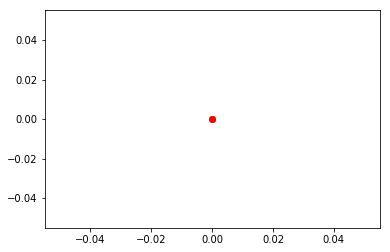

In [32]:
for item in range(len(inv_val)):
    if inv_val[item,0] == 0:
        print(inv_val[item,1], inv_val[item,2])
        plt.plot(inv_val[item,1], inv_val[item,2], 'ro')
plt.show()